# Importing liberaries

In [1]:
import zipfile
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [3]:
#print(device_lib.list_local_devices())
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moaaz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moaaz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Preprocessing the dataset

In [6]:
data= pd.read_csv('../training.1600000.processed.noemoticon.csv.zip',  encoding='ISO-8859-1', names=['1','2','3','4','5', '6'], header =None )

In [7]:
data.head()

,1,2,3,4,5,6
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
#number of records in the dataset
print('The number of records in the dataset is '+ str(len(data))+ ' record.') 

The number of records in the dataset is 1600000 record.


In [9]:
#checking for null values
data.isnull().sum().sum() 

0

In [10]:
#change the target and tweets columns' names 
data = data.rename(columns = {'1': 'targ', '6': 'texts'})

In [11]:
data['targ'][data['targ']==4]=1

C:\Users\moaaz\AppData\Local\Temp/ipykernel_6064/3684360877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['targ'][data['targ']==4]=1


In [12]:
data_pos = data[data['targ'] == 1]
data_neg = data[data['targ'] == 0]

In [13]:
print(len(data_pos))
print(len(data_neg))

800000
800000


In [14]:
#data_pos = data_pos.iloc[:int(50000)]
#data_neg = data_neg.iloc[:int(50000)]

In [15]:
data = pd.concat([data_pos, data_neg])

In [16]:
data

,targ,2,3,4,5,texts
800000,1,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,1,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,1,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,1,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
...,...,...,...,...,...,...
799995,0,2329205009,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,dandykim,Sick Spending my day laying in bed listening ...
799996,0,2329205038,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,bigenya,Gmail is down?
799997,0,2329205473,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,LeeLHoke,rest in peace Farrah! So sad
799998,0,2329205574,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,davidlmulder,@Eric_Urbane Sounds like a rival is flagging y...


In [17]:
data_nw = data.drop(columns = ['2','3','4','5'])

data_nw.head()

,targ,texts
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


# Text preprocessing

In [18]:
#stop words list 
list_old_stp_wrds = stopwords.words('english')
len(list_old_stp_wrds)

179

In [19]:
list_stp_wrds =[]
for stpwrd in list_old_stp_wrds:
    
    if stpwrd.endswith("n't") or stpwrd.endswith("dn") or stpwrd.endswith("sn"):
        print(stpwrd)
    else:
        list_stp_wrds.append(stpwrd)
        
len(list_stp_wrds)    #updated  

don't
aren't
couldn
couldn't
didn
didn't
doesn
doesn't
hadn
hadn't
hasn
hasn't
haven't
isn
isn't
mightn't
mustn't
needn
needn't
shan't
shouldn
shouldn't
wasn
wasn't
weren't
won't
wouldn
wouldn't


151

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moaaz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
def Preprocessing(tw):
    
    emoji = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
              ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
              ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
              ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
              '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
              '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
              ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

    links = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    mentions = r"@[^\s]+"
    nonalpha = '[^a-zA-Z0-9]'
    
    
    
    tw = re.sub(links,'',tw)
    
    tw = re.sub(mentions, '', tw) 
    
    
    
    for em in emoji.keys():
        tw = tw.replace(em, emoji[em])   
    
    tw = re.sub(nonalpha, " ", tw)     
    
    tokens = word_tokenize(tw)   
    lemm = '';
    
    for wrd in tokens:
        if wrd not in list_stp_wrds:  
            if len(wrd) > 1:
                obj = WordNetLemmatizer()
                  

                lem_wrd = obj.lemmatize(wrd)  
                lemm += (lem_wrd + ' ')    
    
    return lemm.strip()

In [22]:
data_nw['texts'] = data_nw['texts'].apply(Preprocessing)
data_nw['texts']

800000                                        LOVE guy best
800001    im meeting one besties tonight Cant wait GIRL ...
800002    Thanks Twitter add Sunisa got meet HIN show DC...
800003    Being sick really cheap hurt much eat real foo...
800004                                      effect everyone
                                ...                        
799995               Sick Spending day laying bed listening
799996                                                Gmail
799997                             rest peace Farrah So sad
799998        Sounds like rival flagging ad Not much though
799999    resit exam summer wish worked harder first yea...
Name: texts, Length: 1600000, dtype: object

In [23]:
X=data.texts
y=data.targ

Preparing the input features for training 

We converting the text words into arrays form.
Maximum 500 features/words selected for training. These 500 words will be selected on the importance that will distinguish between the positive tweets and negative tweets.

In [24]:
max_len = 120
num_of_words = 9999
tok = Tokenizer(num_words= num_of_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

In [25]:
sequences_matrix.shape

(1600000, 120)

In [26]:
#max_list = [max(s) for s in sequences]
#max_word = max(max_list)
#print(max_word)

total 1600000 tweets and the number words/features are 118

Separating the 70% data for training data and 30% for testing data

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [28]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(shape=(max_len, ))#step1
    layer = Embedding(num_of_words+1 ,64 ,input_length=max_len)(inputs) #step2
    
    layer = SpatialDropout1D(0.4)(layer) # step6
    
    layer = LSTM(128)(layer) #step3
    
    layer = Dropout(0.2, name="LSTM_Dropout")(layer)
    
    #layer = Dense(60,name='FC1')(layer) #step4
    
    layer = Dense(10,name='FC2')(layer) #step4
    #layer = Activation('relu')(layer) # step5
    
    layer = Dense(1,name='out_layer', activation="sigmoid")(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    #layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

In [29]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer= "Adam" ,metrics=['accuracy' , tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall() , tfa.metrics.F1Score(num_classes=1,
                                                  average='macro',
                                                  threshold=0.5)])

In [30]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.int64)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.int64)

X_test = tf.convert_to_tensor(X_test, dtype=tf.int64)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int64)

In [31]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120)]             0         
                                                                 
 embedding (Embedding)       (None, 120, 64)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 120, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 LSTM_Dropout (Dropout)      (None, 128)               0         
                                                                 
 FC2 (Dense)                 (None, 10)                1290      
                                                             

In [32]:
import os
from tensorflow.keras import callbacks

check_path = "training_1cp.ckpt"
check_dir = os.path.dirname(check_path)
back_path = "backup"
back_dir = os.path.dirname(back_path)
ten_path = "Tensor"
ten_dir = os.path.dirname(ten_path)

cp_callbacks = [callbacks.EarlyStopping(monitor="val_accuracy", patience=4, verbose=1, restore_best_weights=True),
               callbacks.ModelCheckpoint(monitor="val_accuracy", filepath=check_path, save_best_only=True, save_weights_only=True)]

In [33]:
history=model.fit(X_train,Y_train,batch_size=150,epochs=20, validation_split=0.2, callbacks=[cp_callbacks])# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/20
5974/5974 [==============================] - 115s 18ms/step - loss: 0.4366 - accuracy: 0.7975 - precision: 0.8025 - recall: 0.7888 - f1_score: 0.7956 - val_loss: 0.4051 - val_accuracy: 0.8146 - val_precision: 0.8111 - val_recall: 0.8224 - val_f1_score: 0.8167
Epoch 2/20
5974/5974 [==============================] - 111s 19ms/step - loss: 0.4007 - accuracy: 0.8178 - precision: 0.8209 - recall: 0.8128 - f1_score: 0.8168 - val_loss: 0.3973 - val_accuracy: 0.8193 - val_precision: 0.8098 - val_recall: 0.8369 - val_f1_score: 0.8231
Epoch 3/20
5974/5974 [==============================] - 118s 20ms/step - loss: 0.3883 - accuracy: 0.8244 - precision: 0.8272 - recall: 0.8198 - f1_score: 0.8235 - val_loss: 0.3913 - val_accuracy: 0.8227 - val_precision: 0.8263 - val_recall: 0.8194 - val_f1_score: 0.8228
Epoch 4/20
5974/5974 [==============================] - 114s 19ms/step - loss: 0.3790 - accuracy: 0.8292 - precision: 0.8319 - recall: 0.8250 - f1_score: 0.8284 - val_loss: 0.3901 - val_a

In [34]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

15000/15000 [==============================] - 127s 8ms/step - loss: 0.3990 - accuracy: 0.8256 - precision: 0.8280 - recall: 0.8213 - f1_score: 0.8246


In [35]:
print('Test set\n  Accuracy: {:0.2f}%'.format(accr1[1]*100)) #the accuracy of the model on test data is given below
print('  Loss: {:0.2f}'.format(accr1[0])) #the Loss of the model on test data is given below
print('  precision: {:0.2f}'.format(accr1[2])) #the precision of the model on test data is given below
print('  recall: {:0.2f}'.format(accr1[3])) #the recall of the model on test data is given below
print('  f1_score: {:0.2f}'.format(accr1[4])) #the f1_score of the model on test data is given below

Test set
  Accuracy: 82.56%
  Loss: 0.40
  precision: 0.83
  recall: 0.82
  f1_score: 0.82


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


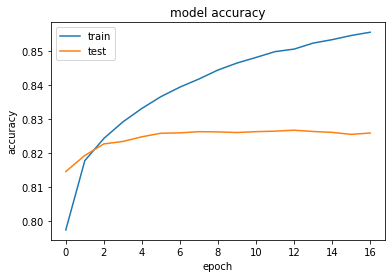

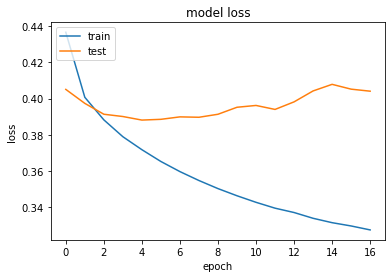

In [36]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()